<a href="https://www.kaggle.com/code/piotrpowroznik/gravimetric-model?scriptVersionId=266445369" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Gravimetric Model
Model of gravity force at the ground surface, simulated in 500x250 grid with nodes spaced 1 meter apart. Model consists of background with density of 3500 kg/m3 and 3 randomly located ore bodies with diameter of 100 meters and density 5500 kg/m3.
Model was simulated for nodes 100-400.

Gravity anomalies caused by discretized two-dimensional continuous body were calculated using Talwani algorithm modified by Blakely:
$$
g = 2 \gamma \rho \sum_{n=1}^N \frac{\beta_{n}}{1+a_{n}^2}[log{\frac{r_{n+1}}{r_{n}}} - a_{n}(\theta_{n+1}-\theta_{n})]
$$

$$Where:$$
$$\gamma = 6.67 \times 10^{-11} \left[ \frac{m^3}{kg\cdot s^2} \right]$$
$$\rho - node\ density$$
$$r_{n+1}, r_{n} - distance\ between\ measurement\ point\ and\ neighboring\ vertex\ of\ rectangle\ assigned\ to\ node$$
$$\theta_{n+1}, \theta_{n} - angle\ between\ x\ axis\ and\ radius\ designated\ form\ measurement\ point\ to\ neighboring\ vertex$$
$$\alpha_{n} = \frac{x_{n+1}-x_{n}}{z_{n+1}-z_{n}}$$
$$\beta_{n} = x_{n}-\alpha_{n}z_{n} $$
$$x_{n}, z_{n} - node\ coordinates$$

In [1]:
library(doSNOW)
library(foreach)

Loading required package: foreach



Loading required package: iterators



Loading required package: snow



## Define Functions

In [2]:
# Function for calculating distance
getR <- function(j, i, k) {
  return(sqrt(((j - k)^2) + (i^2)))
}

# Function for calculating angle
getAngle <- function(j, i, k) {
  if (k == j) {
    return(90.0)
  }
  
  ii <- abs(j - k)
  tg <- i / ii
  rad <- atan(tg)
  deg <- (rad / pi) * 180
  return(deg)
}

## Initial Properties

In [3]:
# Create and register cluster
cl <- makeCluster(7)
registerDoSNOW(cl)

# Start time measurement
start <- Sys.time()

# Dimensions
N <- 500
M <- 250

# Densities
rho1 <- 3500
rho2 <- 5500

# Gravitational constant
gamma <- 6.67e-11

# Density matrix
rho <- matrix(nrow = M, ncol = N, rho1)


## Define Model

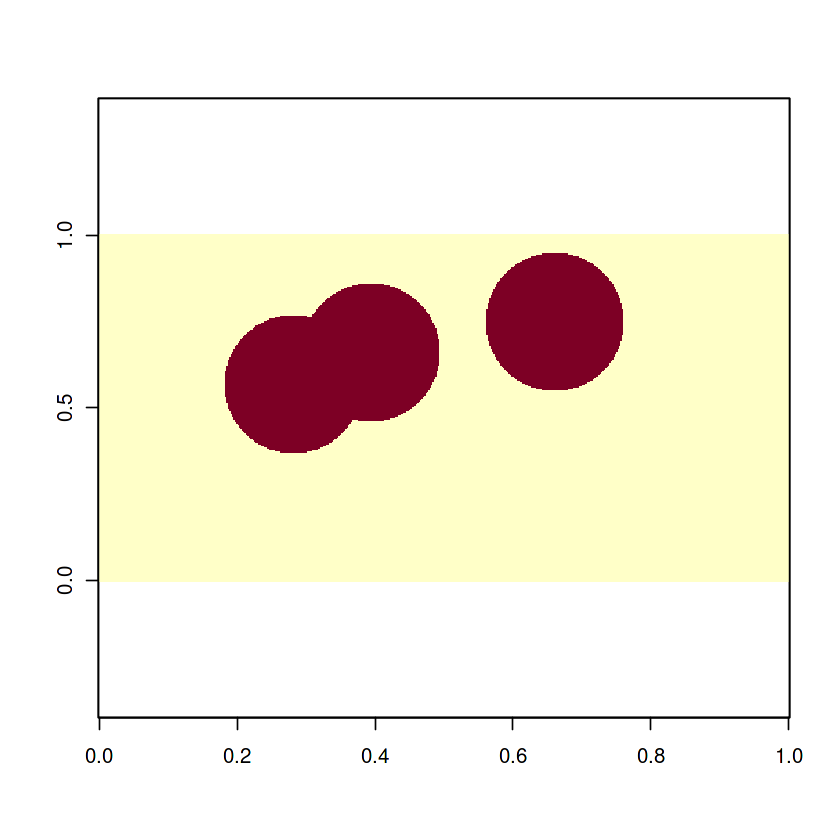

In [4]:
# Model generation
for (k in 1:3) {
  x <- round(100 + runif(1) * (N - 200))
  z <- round(50 + runif(1) * (M - 100))
  
  for (i in 1:M) {
    for (j in 1:N) {
      if (sqrt((i - z)^2 + (j - x)^2) < 50)
        rho[i, j] <- rho2
    }
  }
}

# Display the generated model
image(t(apply(rho, 2, rev)), asp = 0.5)
box()

## Simulate Model

In [5]:
# Vector for results
g <- rep(0, N)

# Parallel computation
out <- foreach(k = seq(100, 400, 1)) %dopar% {
  suma <- 0
  
  for (i in 1:M) {
    for (j in 1:N) {
      beta <- (i + 1 - i) / (j + 1 - j)
      r <- getR(j, i, k)
      r1 <- getR(j, i + 1, k)
      z <- r1 / r
      logarytm <- log(z)
      a <- getAngle(j, i, k)
      a1 <- getAngle(j, i + 1, k)
      suma <- suma + (rho[i, j] * beta * (logarytm - (a - a1)))
    }
  }
  g <- 2 * gamma * suma
}

# Stop time measurement
stop <- Sys.time()

# Print time difference
stop - start

# Declare matrix
m <- matrix(nrow = 10, ncol = 1000, 0)

# Assign results to matrix
m <- unlist(out)

# Release the cluster
stopCluster(cl)


Time difference of 3.685333 mins

## Results
The result of the program execution is a plot of the gravitational response of the generated model, which allows for determining the location of anomalies related to density variations.

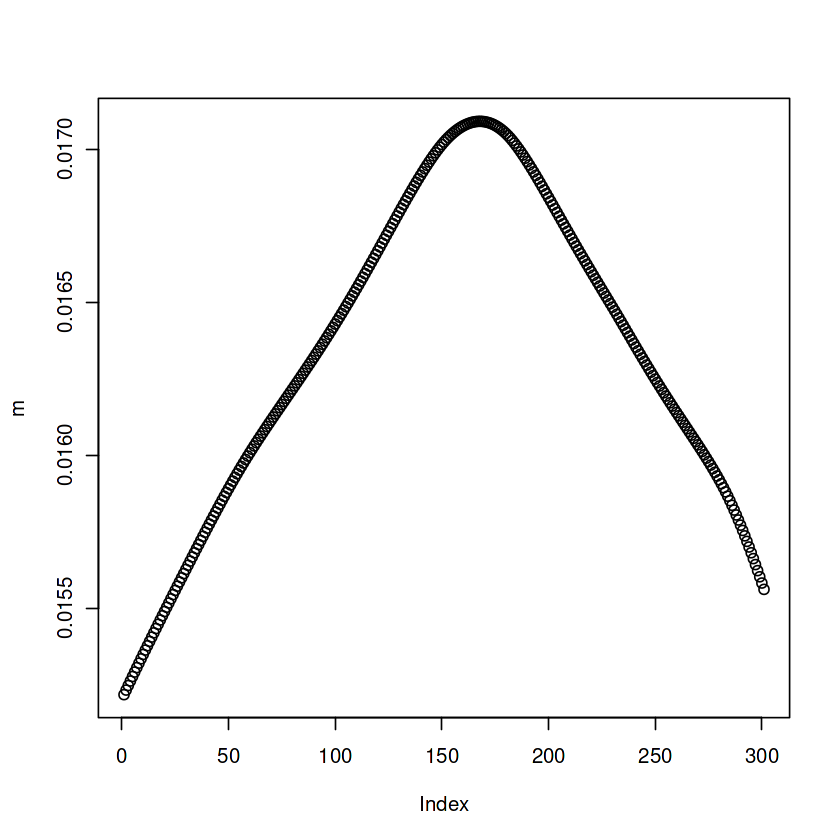

In [6]:
plot(m)
